# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
Description here

## Import Packages

In [1]:
#importing some useful packages
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Load test images
Our first step is to load and visualize the test images.

In [2]:
test_img_dir = 'test_images/'
test_img_names = os.listdir(test_img_dir)
test_img_names = [test_img_dir + name for name in test_img_names]
test_img_names 

['test_images/solidYellowCurve.jpg',
 'test_images/solidYellowLeft.jpg',
 'test_images/solidYellowCurve2.jpg',
 'test_images/solidWhiteRight.jpg',
 'test_images/whiteCarLaneSwitch.jpg',
 'test_images/solidWhiteCurve.jpg']

In [3]:
test_imgs = [mpimg.imread(name) for name in test_img_names]

In [4]:
def show_test_images(test_imgs=test_imgs, test_img_names=test_img_names, cols=2, figsize=(10, 10)):
    img_count = len(test_imgs)
    rows = np.ceil(img_count / cols)
    cmap = None
    
    plt.figure(figsize=figsize)
    
    for idx, img in enumerate(test_imgs):
        img_name = test_img_names[idx]
        plt.subplot(rows, cols, idx+1)
        if len(img.shape) <3:
            cmap='gray'
        
        plt.title(img_name.split('/')[1])
        plt.imshow(img, cmap=cmap)
        
    plt.tight_layout()
    plt.show()
    
    

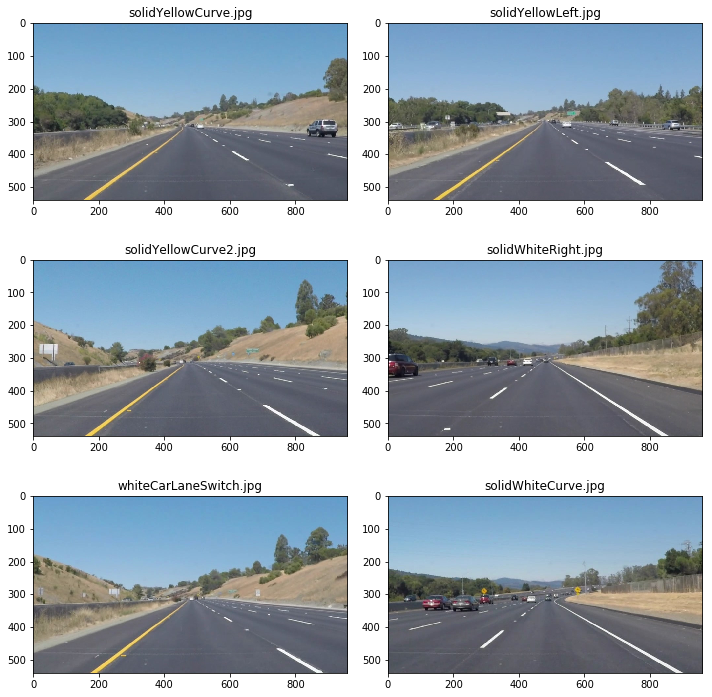

In [5]:
show_test_images()

## Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Pipeline
The pipeline for detecting lane lines consists of the following steps:
* Select region of interest
* Color masking: Detect yellow and white
* Convert image to grayscale
* Gaussian blurring
* Canny edge detection
* Hough transform
* Separate left and right lines
* Average them to one left and one right lane
* Extrapolate two continuous lanes 

## Helper Functions

In [6]:
import math

# try this again later. I now think that vertices are the same as apex, left_bottom and right_bottom in 
# region_of_interest2.
def region_of_interest(img, vertices=[]):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def region_of_interest2(img):
    """Implementation of region of interest selection like in the lectures"""
    # Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
    # np.polyfit returns the coefficients [A, B] of the fit
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    left_bottom = [80, ysize]
    right_bottom = [xsize - 50, ysize]
    apex = [int(xsize/2), int(ysize/2)]
    
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))
    
    # Mask region selection
    image = np.copy(img)
    # write if else depending on number of color channels e.g. [0, 0, 0] for three channesl
    image[~region_thresholds] = 0
    return image

def to_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def get_white_stuff_rgb(img):
    low_threshold = np.array([220, 220, 220], dtype=np.uint8)
    high_threshold = np.array([255, 255, 255], dtype=np.uint8)
    white_mask = cv2.inRange(img, low_threshold, high_threshold)
    return white_mask

def get_yellow_stuff(img):
    img = to_hls(img)
    low_threshold = np.array([20, 100, 100], dtype=np.uint8)
    high_threshold = np.array([30, 255, 255], dtype=np.uint8)
    yellow_mask = cv2.inRange(img, low_threshold, high_threshold)
    return yellow_mask

def color_select(img):
    yellow_mask = get_yellow_stuff(img)
    white_mask = get_white_stuff_rgb(img)
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    return cv2.bitwise_and(img, img, mask=mask)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(image=img, threshold1=50, threshold2=150)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def draw_lanes(img, lines):
    left_lanes, right_lanes = separate_lanes(img, lines)
    draw_lanes_different_color(img, left_lanes, right_lanes, left_lane_color=[255, 0, 0], 
                               right_lane_color=[0, 0, 255], thickness=2)

        
    

def hough_lines(img, rho=1, theta=np.pi/180, threshold=1, min_line_len=10, max_line_gap=1):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lanes(line_img, lines)
    return line_img


def separate_lanes(img, lines):
    left_lanes = []
    right_lanes = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            delta_x = x2 - x1
            # discard lines delta_x == 0 or delta_y == 0 because slope can't be computed or
            # lines can not be identified as left or right
            if(delta_x == 0): 
                continue
            delta_y = y2 - y1
            if (delta_y == 0):
                continue
            
            slope =delta_y / delta_x
            
            # discard horizontal lines, i.e. lines with small slope
            horizontal_threshold = 0.1
            if abs(slope) < horizontal_threshold:
                continue
            
            # possible improvement: also check if identified 'left line' is in the left part of the image
            if (slope < 0):
                left_lanes.append([[x1, y1, x2, y2]])
            else:
                right_lanes.append([[x1, y1, x2, y2]])
    print('number of left lanes %d' %len(left_lanes))
    print('number of right lanes %d' %len(right_lanes))
                
    return left_lanes, right_lanes
    
def draw_lanes_different_color(img, left_lanes, right_lanes, left_lane_color=[255, 0, 0], right_lane_color=[0, 0, 255], 
                               thickness=2):
    """colors the left lane lines red and the right lane lines blue."""
    left_lane_image=draw_lines(img, left_lanes, left_lane_color, thickness)
    right_lane_image=draw_lines(left_lane_image, right_lanes, right_lane_color, thickness)
    ### here is something missing. We want both lanes be drawn on the same image!!

    
def draw_lines(img, lines, color, thickness):
        
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test the Pipeline

### Region of interest
We assume that the camera is mounted at a fixed position on the vehicle. 

### HSL color space
It is quite tricky to get color thresholds for yellow in the RGB space. Therefore, we switch into HSV color space to isolate yellow objects from the image. The advantage of this transformation is 

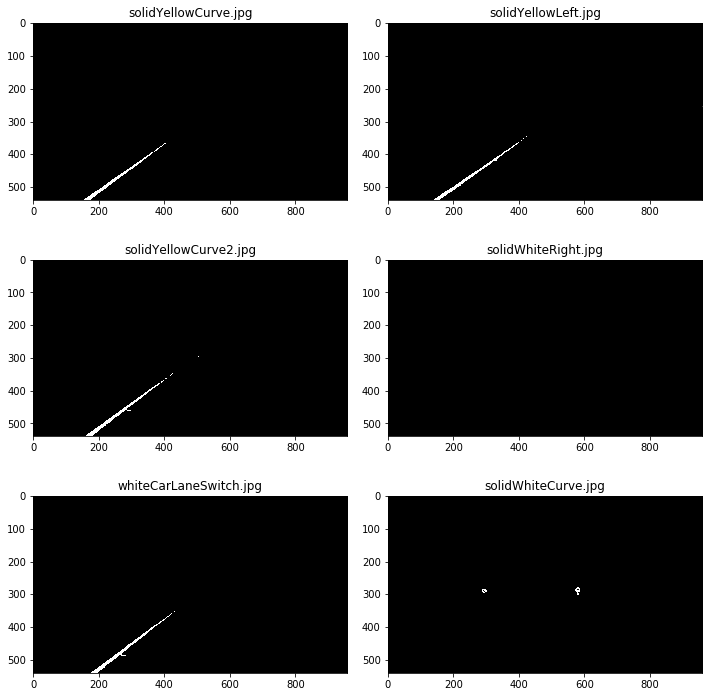

In [7]:
yellow_imgs = [get_yellow_stuff(img) for img in test_imgs]
    
show_test_images(yellow_imgs)
    

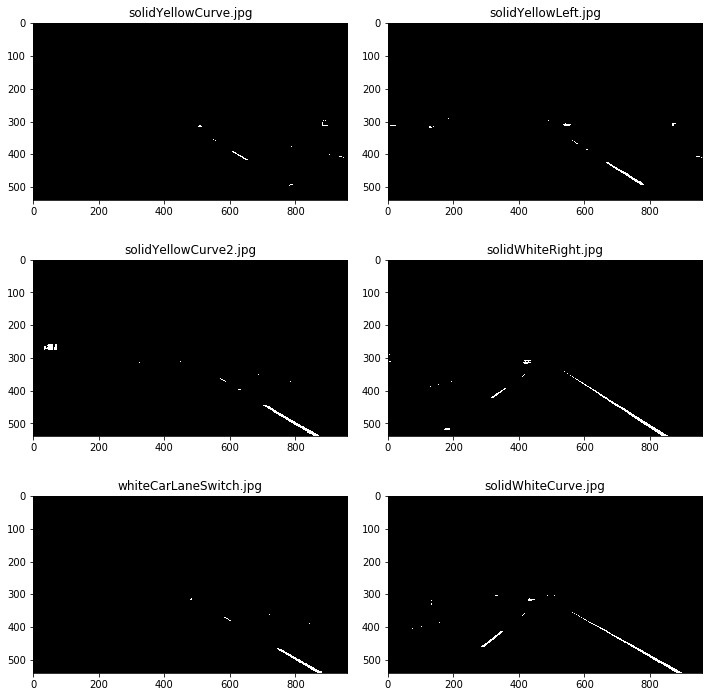

In [8]:
white_sel_imgs = [get_white_stuff_rgb(img) for img in test_imgs]
show_test_images(white_sel_imgs)

In [9]:
# region_sel = [region_of_interest2(img) for img in test_imgs]
# color_sel = [color_select(img) for img in test_imgs]

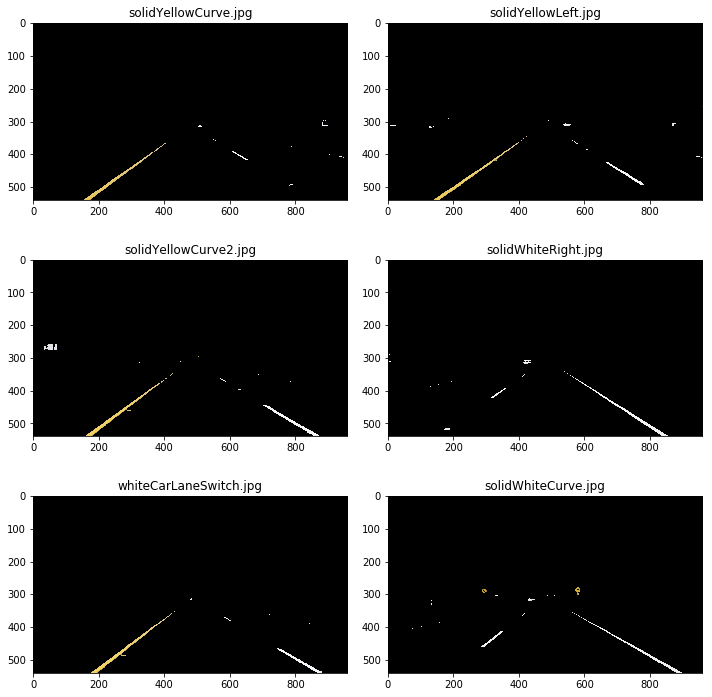

In [10]:
color_sel = [color_select(img) for img in test_imgs]
show_test_images(color_sel)

This looks good. Now we convert to grayscale.

### Grayscale


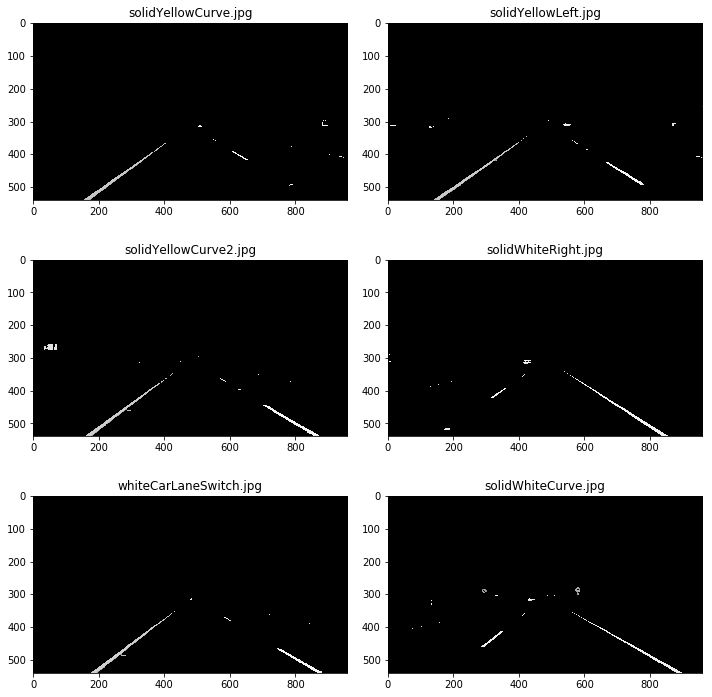

In [11]:
gray_imgs = [grayscale(img) for img in color_sel]
show_test_images(gray_imgs)

This looks pretty good. Maybe we need a bit more space on the right. Next, we try select the relevant region around the lines. 

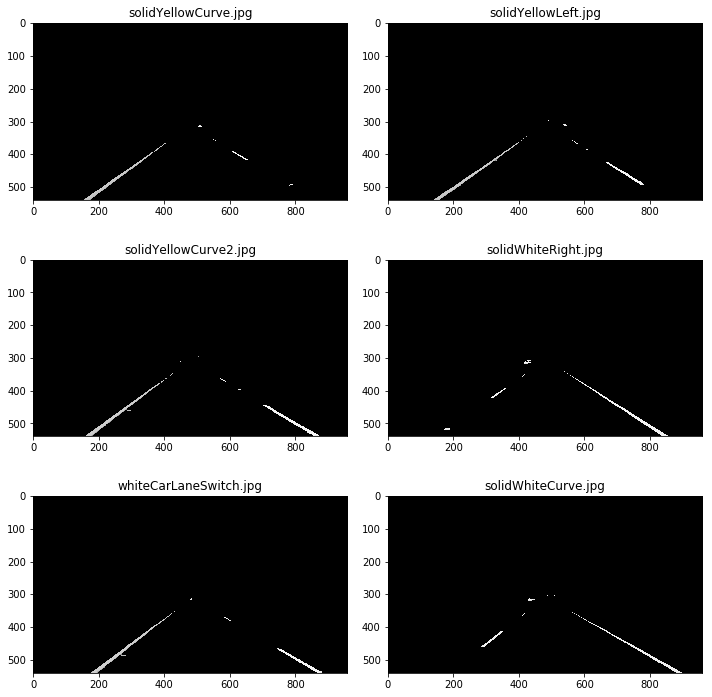

In [12]:
region_sel = [region_of_interest2(img) for img in gray_imgs]
show_test_images(region_sel)

This seems to be working. Maybe be a little more generous with the region selection.

As an alternative, we try also the pre-defined version for region selection. 

### Gaussian Blur


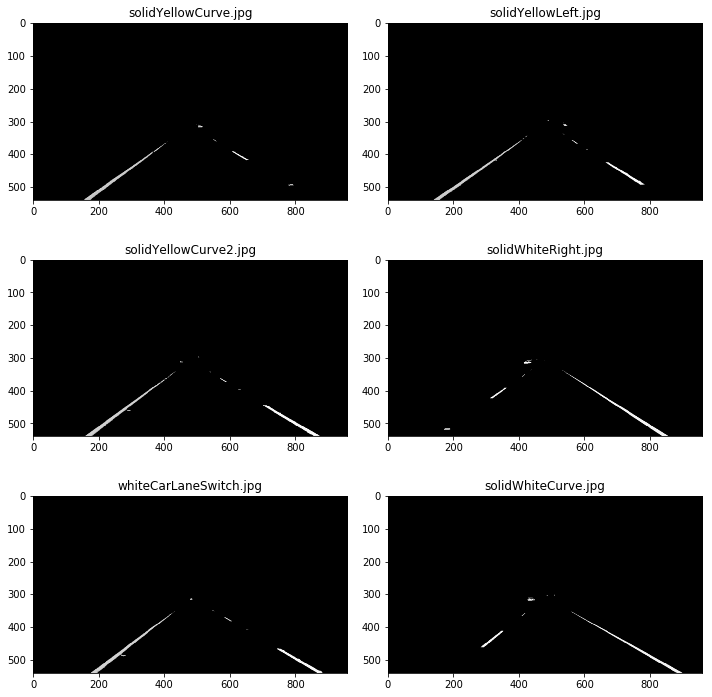

In [13]:
gaussian_imgs = [gaussian_blur(img, kernel_size=3) for img in region_sel]
show_test_images(gaussian_imgs)

### Canny Edge Detection
Next, we apply Canny edge detection. This method has the parameters `low_threshold` and `high_threshold`. Values greater than the high threshold are included in an edge, while values between low_threshold and high_threshold are only included, if they are next to an edge pixel. Usually, the ration between low_threshold and high_threshold should be 1:2 or 1:3.

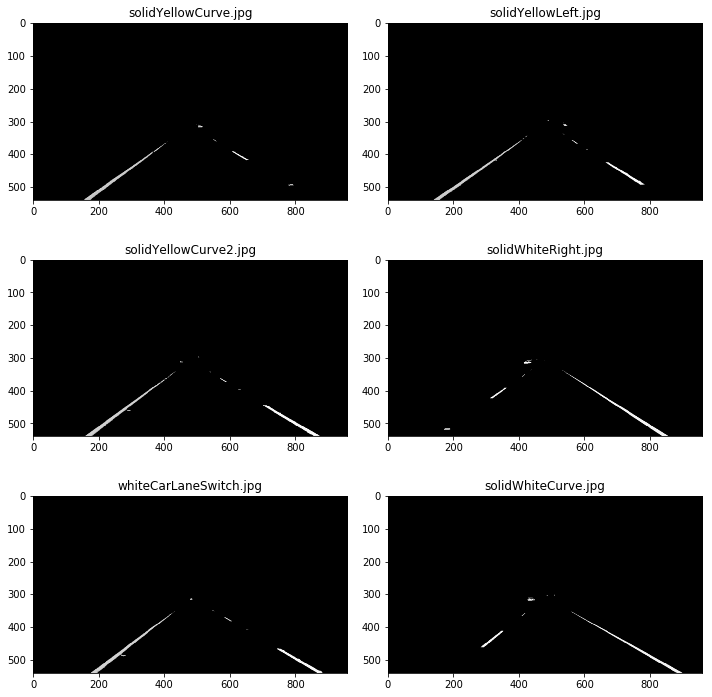

In [14]:
canny_imgs = [canny(img, low_threshold=50, high_threshold=150) for img in gaussian_imgs]
show_test_images(gaussian_imgs)

### Hough Transformation
Next, hough transformation interpolates lines from the detected edges. Parameters are: `rho`, `theta`, `threshold`, `min_line_len`, `max_line_gap`. We start with the following values:
* rho = 1
* theta = np.pi/180
* threshold = 1
* min_line_length = 10
* max_line_gap = 1

number of left lanes 9
number of right lanes 4
number of left lanes 9
number of right lanes 5
number of left lanes 10
number of right lanes 7
number of left lanes 3
number of right lanes 11
number of left lanes 10
number of right lanes 6
number of left lanes 4
number of right lanes 14


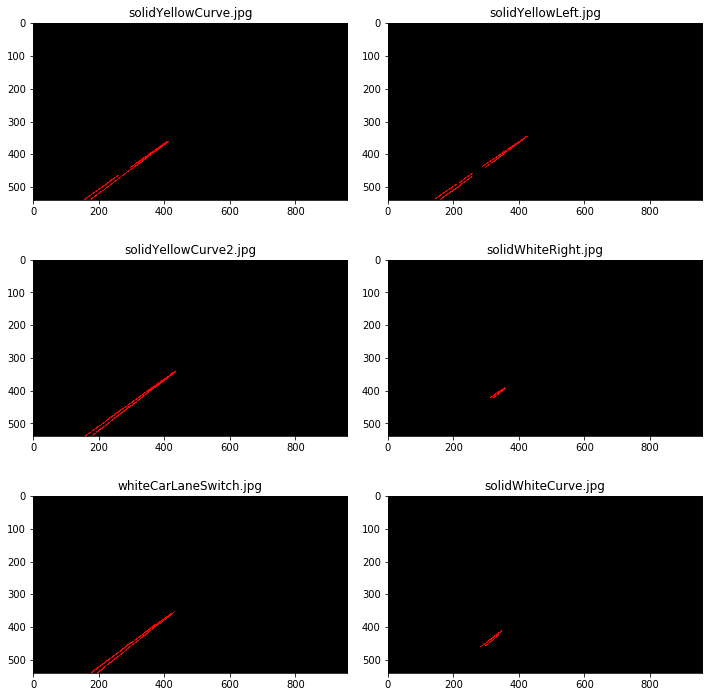

In [15]:
hough_imgs = [hough_lines(img, min_line_len=25, max_line_gap=10) for img in canny_imgs]
show_test_images(hough_imgs)

We see that the parameters `min_line_len=25` and `max_line_gap=10` work reasonably well. 

### Creating a Pipeline
Now it's time to create a pipeline function that combines the above steps.

In [16]:
def detect_lane_lines(img):
    # color selection
    color_img = color_select(img)
    # grayscaling
    gray_img = grayscale(color_img)
    # region selection
    region_img = region_of_interest2(gray_img)
    # gaussian blur
    gaussian_img = gaussian_blur(region_img)
    # canny edge detection
    canny_img = canny(gaussian_img, low_threshold=50, high_threshold=150)
    # hough transform
    hough_img = hough_lines(canny_img, min_line_len=25, max_line_gap=10)
    ##############################################
    # here is going to be the draw_lines function
    #############################################
    # draw lines on image
    weighted_image = weighted_img(img=hough_img, initial_img=img)
    return weighted_image


number of left lanes 11
number of right lanes 3
number of left lanes 12
number of right lanes 6
number of left lanes 16
number of right lanes 7
number of left lanes 3
number of right lanes 7
number of left lanes 7
number of right lanes 7
number of left lanes 4
number of right lanes 11


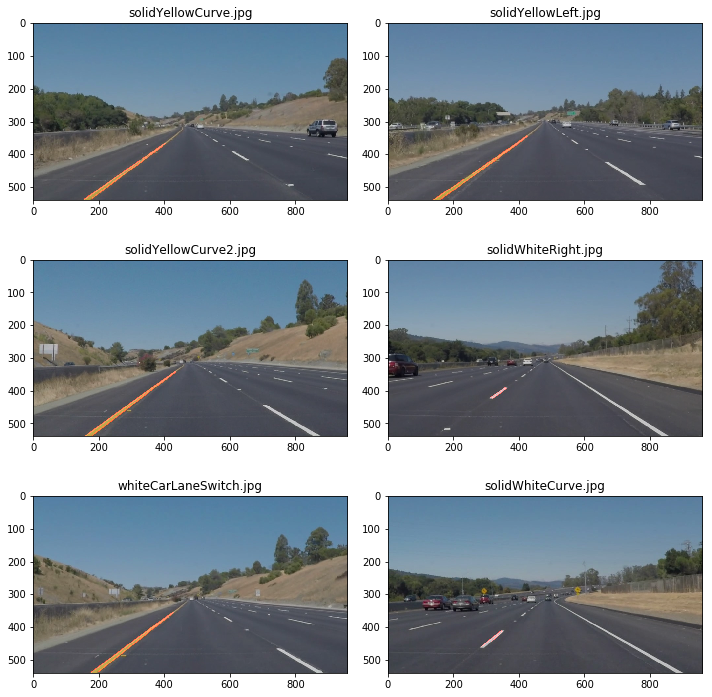

In [17]:
analyzed_imgs = [detect_lane_lines(img) for img in test_imgs]
show_test_images(analyzed_imgs)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [19]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detect_lane_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

number of left lanes 4
number of right lanes 14
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|▏         | 3/222 [00:00<00:08, 25.66it/s]

number of left lanes 4
number of right lanes 14
number of left lanes 7
number of right lanes 8
number of left lanes 6
number of right lanes 13
number of left lanes 5
number of right lanes 10
number of left lanes 0
number of right lanes 12


  3%|▎         | 7/222 [00:00<00:07, 28.66it/s]

number of left lanes 2
number of right lanes 13
number of left lanes 2
number of right lanes 14


  5%|▍         | 10/222 [00:00<00:08, 25.90it/s]

number of left lanes 2
number of right lanes 6
number of left lanes 4
number of right lanes 12
number of left lanes 3
number of right lanes 13
number of left lanes 4
number of right lanes 12
number of left lanes 5
number of right lanes 14


  7%|▋         | 15/222 [00:00<00:09, 22.79it/s]

number of left lanes 6
number of right lanes 7
number of left lanes 5
number of right lanes 15
number of left lanes 5
number of right lanes 12
number of left lanes 4
number of right lanes 11
number of left lanes 1
number of right lanes 12


  8%|▊         | 18/222 [00:00<00:09, 22.32it/s]

number of left lanes 1
number of right lanes 8
number of left lanes 3
number of right lanes 14
number of left lanes 3
number of right lanes 14
number of left lanes 3
number of right lanes 14


 10%|▉         | 22/222 [00:00<00:07, 25.25it/s]

number of left lanes 3
number of right lanes 11
number of left lanes 3
number of right lanes 9


 11%|█▏        | 25/222 [00:01<00:08, 22.77it/s]

number of left lanes 6
number of right lanes 11
number of left lanes 5
number of right lanes 10
number of left lanes 7
number of right lanes 15
number of left lanes 6
number of right lanes 7


 13%|█▎        | 28/222 [00:01<00:09, 19.84it/s]

number of left lanes 3
number of right lanes 8
number of left lanes 0
number of right lanes 9


 14%|█▍        | 31/222 [00:01<00:09, 19.28it/s]

number of left lanes 2
number of right lanes 8
number of left lanes 2
number of right lanes 10


 15%|█▍        | 33/222 [00:01<00:10, 18.78it/s]

number of left lanes 3
number of right lanes 6
number of left lanes 3
number of right lanes 6


 16%|█▌        | 35/222 [00:01<00:10, 18.31it/s]

number of left lanes 4
number of right lanes 12
number of left lanes 5
number of right lanes 9


 17%|█▋        | 38/222 [00:01<00:09, 19.99it/s]

number of left lanes 4
number of right lanes 10
number of left lanes 5
number of right lanes 12
number of left lanes 8
number of right lanes 10
number of left lanes 6
number of right lanes 7


 19%|█▉        | 42/222 [00:01<00:07, 23.23it/s]

number of left lanes 3
number of right lanes 8
number of left lanes 0
number of right lanes 10
number of left lanes 2
number of right lanes 8


 21%|██        | 47/222 [00:01<00:06, 27.03it/s]

number of left lanes 2
number of right lanes 8
number of left lanes 3
number of right lanes 12
number of left lanes 4
number of right lanes 8
number of left lanes 3
number of right lanes 7
number of left lanes 5
number of right lanes 10
number of left lanes 4
number of right lanes 12
number of left lanes 7
number of right lanes 10
number of left lanes 3
number of right lanes 6
number of left lanes 6
number of right lanes 8


 26%|██▌       | 57/222 [00:02<00:04, 33.35it/s]

number of left lanes 6
number of right lanes 8
number of left lanes 0
number of right lanes 6
number of left lanes 1
number of right lanes 11
number of left lanes 3
number of right lanes 12
number of left lanes 3
number of right lanes 9
number of left lanes 4
number of right lanes 10
number of left lanes 3
number of right lanes 7
number of left lanes 4
number of right lanes 8
number of left lanes 4
number of right lanes 11


 27%|██▋       | 61/222 [00:02<00:04, 34.22it/s]

number of left lanes 7
number of right lanes 6
number of left lanes 6
number of right lanes 6
number of left lanes 5
number of right lanes 11
number of left lanes 3
number of right lanes 11


 29%|██▉       | 65/222 [00:02<00:04, 33.16it/s]

number of left lanes 0
number of right lanes 9
number of left lanes 1
number of right lanes 13
number of left lanes 1
number of right lanes 14


 32%|███▏      | 70/222 [00:02<00:04, 35.41it/s]

number of left lanes 2
number of right lanes 8
number of left lanes 4
number of right lanes 9
number of left lanes 2
number of right lanes 14
number of left lanes 4
number of right lanes 7
number of left lanes 4
number of right lanes 14
number of left lanes 7
number of right lanes 11


 34%|███▍      | 75/222 [00:02<00:03, 37.52it/s]

number of left lanes 5
number of right lanes 7
number of left lanes 5
number of right lanes 12
number of left lanes 4
number of right lanes 12


 36%|███▌      | 80/222 [00:02<00:03, 39.42it/s]

number of left lanes 3
number of right lanes 13
number of left lanes 3
number of right lanes 8
number of left lanes 2
number of right lanes 14
number of left lanes 2
number of right lanes 13
number of left lanes 3
number of right lanes 11
number of left lanes 3
number of right lanes 13


 38%|███▊      | 85/222 [00:02<00:03, 40.60it/s]

number of left lanes 2
number of right lanes 12
number of left lanes 4
number of right lanes 10
number of left lanes 7
number of right lanes 12


 41%|████      | 90/222 [00:02<00:03, 41.30it/s]

number of left lanes 7
number of right lanes 13
number of left lanes 6
number of right lanes 11
number of left lanes 4
number of right lanes 11
number of left lanes 3
number of right lanes 7
number of left lanes 2
number of right lanes 7
number of left lanes 3
number of right lanes 9
number of left lanes 4
number of right lanes 14
number of left lanes 2
number of right lanes 12
number of left lanes 4
number of right lanes 12
number of left lanes 5
number of right lanes 11


 45%|████▌     | 100/222 [00:03<00:02, 43.17it/s]

number of left lanes 6
number of right lanes 7
number of left lanes 4
number of right lanes 11
number of left lanes 5
number of right lanes 13
number of left lanes 5
number of right lanes 16
number of left lanes 4
number of right lanes 10
number of left lanes 4
number of right lanes 8
number of left lanes 1
number of right lanes 8
number of left lanes 1
number of right lanes 12
number of left lanes 2
number of right lanes 9
number of left lanes 3
number of right lanes 11


 50%|████▉     | 110/222 [00:03<00:02, 44.18it/s]

number of left lanes 4
number of right lanes 9
number of left lanes 3
number of right lanes 15
number of left lanes 6
number of right lanes 10
number of left lanes 4
number of right lanes 9
number of left lanes 6
number of right lanes 16
number of left lanes 3
number of right lanes 5


 52%|█████▏    | 115/222 [00:03<00:02, 44.45it/s]

number of left lanes 5
number of right lanes 10
number of left lanes 2
number of right lanes 5
number of left lanes 0
number of right lanes 17
number of left lanes 2
number of right lanes 12


 54%|█████▍    | 120/222 [00:03<00:02, 44.40it/s]

number of left lanes 2
number of right lanes 12
number of left lanes 2
number of right lanes 15
number of left lanes 4
number of right lanes 7
number of left lanes 4
number of right lanes 10
number of left lanes 5
number of right lanes 6
number of left lanes 5
number of right lanes 7
number of left lanes 6
number of right lanes 11
number of left lanes 7
number of right lanes 9
number of left lanes 4
number of right lanes 10


 59%|█████▊    | 130/222 [00:03<00:02, 44.00it/s]

number of left lanes 4
number of right lanes 11
number of left lanes 1
number of right lanes 15
number of left lanes 1
number of right lanes 15
number of left lanes 2
number of right lanes 5
number of left lanes 3
number of right lanes 15
number of left lanes 4
number of right lanes 15
number of left lanes 4
number of right lanes 7
number of left lanes 5
number of right lanes 6
number of left lanes 4
number of right lanes 12


 63%|██████▎   | 140/222 [00:04<00:01, 44.78it/s]

number of left lanes 5
number of right lanes 7
number of left lanes 7
number of right lanes 11
number of left lanes 4
number of right lanes 14
number of left lanes 5
number of right lanes 11
number of left lanes 0
number of right lanes 8
number of left lanes 0
number of right lanes 9
number of left lanes 4
number of right lanes 9
number of left lanes 2
number of right lanes 11
number of left lanes 4
number of right lanes 8
number of left lanes 5
number of right lanes 14


 68%|██████▊   | 150/222 [00:04<00:01, 45.24it/s]

number of left lanes 5
number of right lanes 9
number of left lanes 4
number of right lanes 16
number of left lanes 6
number of right lanes 14
number of left lanes 7
number of right lanes 6
number of left lanes 5
number of right lanes 11
number of left lanes 3
number of right lanes 11
number of left lanes 0
number of right lanes 15
number of left lanes 2
number of right lanes 10
number of left lanes 3
number of right lanes 11
number of left lanes 3
number of right lanes 7


 72%|███████▏  | 160/222 [00:04<00:01, 45.61it/s]

number of left lanes 2
number of right lanes 6
number of left lanes 4
number of right lanes 6
number of left lanes 5
number of right lanes 14
number of left lanes 4
number of right lanes 9
number of left lanes 4
number of right lanes 13
number of left lanes 7
number of right lanes 8
number of left lanes 5
number of right lanes 14
number of left lanes 4
number of right lanes 10
number of left lanes 0
number of right lanes 8
number of left lanes 0
number of right lanes 13


 77%|███████▋  | 170/222 [00:04<00:01, 45.44it/s]

number of left lanes 3
number of right lanes 11
number of left lanes 4
number of right lanes 9
number of left lanes 4
number of right lanes 12
number of left lanes 5
number of right lanes 5
number of left lanes 5
number of right lanes 5
number of left lanes 5
number of right lanes 11
number of left lanes 4
number of right lanes 11
number of left lanes 6
number of right lanes 9
number of left lanes 4
number of right lanes 6
number of left lanes 3
number of right lanes 9


 81%|████████  | 180/222 [00:04<00:00, 45.68it/s]

number of left lanes 0
number of right lanes 15
number of left lanes 1
number of right lanes 6
number of left lanes 3
number of right lanes 8
number of left lanes 2
number of right lanes 19
number of left lanes 2
number of right lanes 15
number of left lanes 3
number of right lanes 7
number of left lanes 5
number of right lanes 8
number of left lanes 3
number of right lanes 11
number of left lanes 6
number of right lanes 14
number of left lanes 5
number of right lanes 16


 83%|████████▎ | 185/222 [00:05<00:00, 45.08it/s]

number of left lanes 6
number of right lanes 15
number of left lanes 3
number of right lanes 16
number of left lanes 0
number of right lanes 13
number of left lanes 0
number of right lanes 11
number of left lanes 1
number of right lanes 7
number of left lanes 3
number of right lanes 11
number of left lanes 3
number of right lanes 15


 86%|████████▌ | 190/222 [00:05<00:00, 45.41it/s]

number of left lanes 3
number of right lanes 18
number of left lanes 3
number of right lanes 12
number of left lanes 5
number of right lanes 17


 90%|█████████ | 200/222 [00:05<00:00, 45.63it/s]

number of left lanes 6
number of right lanes 8
number of left lanes 5
number of right lanes 18
number of left lanes 5
number of right lanes 15
number of left lanes 4
number of right lanes 11
number of left lanes 0
number of right lanes 12
number of left lanes 0
number of right lanes 17
number of left lanes 3
number of right lanes 9
number of left lanes 3
number of right lanes 19
number of left lanes 3
number of right lanes 11
number of left lanes 4
number of right lanes 15


 95%|█████████▍| 210/222 [00:05<00:00, 45.47it/s]

number of left lanes 3
number of right lanes 13
number of left lanes 4
number of right lanes 13
number of left lanes 4
number of right lanes 11
number of left lanes 6
number of right lanes 9
number of left lanes 5
number of right lanes 10
number of left lanes 5
number of right lanes 14
number of left lanes 0
number of right lanes 14
number of left lanes 0
number of right lanes 16
number of left lanes 3
number of right lanes 13


 97%|█████████▋| 215/222 [00:05<00:00, 44.98it/s]

number of left lanes 2
number of right lanes 14
number of left lanes 2
number of right lanes 9
number of left lanes 3
number of right lanes 10
number of left lanes 4
number of right lanes 6
number of left lanes 4
number of right lanes 8
number of left lanes 5
number of right lanes 14
number of left lanes 6
number of right lanes 8
number of left lanes 6
number of right lanes 10


100%|█████████▉| 221/222 [00:05<00:00, 37.42it/s]

number of left lanes 4
number of right lanes 8


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.47 s, sys: 1.5 s, total: 6.98 s
Wall time: 6.21 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**
### Separate left and right lanes
Our goal is to interpolate one line for the left lane line and one line for the right lane line. Therefore, we separate all left hough lines from all right hough lines. If a lines has positive slope, it is a left line. If a line has negative slope, it is a right line. 

In [21]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [22]:
def separate_lanes(img, lines):
    left_lines = []
    right_lines = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            delta_x = x1 - x2
            # discard lines delta_x == 0 or delta_y == 0 because slope can't be computed or
            # lines can not be identified as left or right
            if(delta_x == 0): 
                continue
            delta_y = y1 - y2
            if (delta_y == 0):
                continue
            
            slope =delta_y / delta_x
            
            # discard horizontal lines, i.e. lines with small slope
            horizontal_threshold = 0.1
            if math.abs(slope) < horizontal_threshold:
                continue
            
            # possible improvement: also check if identified 'left line' is in the left part of the image
            if (slope > 0):
                left_lanes.append(line)
            else:
                right_lanes.append(line)
                
        return left_lines, right_lines
                

    

### We test the separation of left and right lines by coloring them differently. 

In [23]:
def draw_lanes_different_color(left_lines, left_lane_color=[255, 0, 0], right_lane_color=[0, 0, 255], 
                               right_lines, thickness=2):
    """colors the left lane lines red and the right lane lines blue."""
    for line in left_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), left_lane_color, thickness)
    for line in right_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), right_lane_color, thickness)
        
    

SyntaxError: non-default argument follows default argument (<ipython-input-23-1c10bc193fc6>, line 1)

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(detect_lane_lines)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
